# An Introduction to Reinforcement Learning: The Cart Pole Environment

> In this tutorial we will look at the well-known cartpole environment for Reinforcement Learning!

## What is Reinforcement Learning?

Reinforcement Learning (RL) is a type of Machine Learning, where agents learn to make decisions in a dynamic environment to maximize a reward.

The typical Reinforcement Learning loop looks like this:

1. The agent receives an *observation*, representing the current state of the environment.
2. Based on the observation and its current *policy*, the agent selects an *action*.
3. The agent performs the action and receives a *reward* based on the environment's new state.

Formally, RL can be understood as solving *Markov Decision Process* (MDP). A MDP is a $5$-tuple $(S, A, T, \pi, R)$, with:

- $S$: state space of the environment
- $A$: action space of the environment, i.e., actions that can be performed by the agent
- $T : S \times A \times S \mapsto [0,1]$: transition function, that describes how actions affect the state of the environment
- $r: S \times A \times S \mapsto \mathbb{R}$: reward function
- $\pi_0: S \mapsto [0,1]$: probability distribution over initial state

The agent selects actions using a *policy* $\pi: S \mapsto A$.
The objective is usually to find the optimal policy $\pi*$, which maximizes the cumulative reward.

In 2016, [Brockman et al.](https://arxiv.org/abs/1606.01540) introduced **OpenAI Gym**: A toolkit for reinforcement learning, that came with environment implementations with a consistent API, allowing rapid prototyping and comparison benchmarks of RL algorithms.
While OpenAI Gym is deprecated by now, a successor was released as [**Gymnasium**](https://gymnasium.farama.org/).

## The Cart Pole Environment

We will start with the *Cart Pole* environment provided by Gymnasium.
In this environment, the agent takes control of a car, trying to balance a pole on it.
In each time step, the agent can accelerate the car either to the left or the right.

You can find more information on the environment in [Gymnasium's Documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

> 1. What is the action space of the cart pole environment?
> 2. What is the state space of the environment?
> 3. How does the transition function look like, if we just consider the position of the cart?
> 4. How does the reward function look like?

Let's see the cart pole environment in action, when our agent acts randomly!

In [25]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# set animations to jshtml to render them in browser
# plt.rcParams["animation.html"] = "jshtml"

SEED = 19
rng = np.random.default_rng(SEED)

def new_seed(rng):
    return rng.integers(10_000).item()

In [26]:
# initalize environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

# if running locally, you can also use the human render mode
# render_mode="human" will visualize the environment in a new pygame window
# env = gym.make("CartPole-v1", render_mode="human")

observation, info = env.reset(seed=19)

# we will store our frames in this list
frames = []

# run one episode
truncated = False
terminated = False

while not (truncated or terminated):
    frames.append(env.render())

    # select a random action
    action = env.action_space.sample()
    # action = agent.predict(observation)

    # apply the selected action to the environment
    observation, reward, terminated, truncated, info = env.step(action)

    # agent.train(reward)

env.close()

Authorization required, but no authorization protocol specified



`frames` now contains the recorded `rgb_array`, which we can visualize using JSHTML:

In [27]:
def replay(frames):
    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])
    ax.axis("off")

    def update(frame):
        img.set_data(frame)
        return [img]

    anim = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)
    plt.close(fig)
    return HTML(anim.to_jshtml())

replay(frames)

What we just visualized is an *episode*: one attempt of the agent to solve the environment, until it is actually solved or a termination condition is met.

> What are the conditions for terminations for *Cart Pole*?

## A Random Agent

Let's start by implementing an agent that just randomly selects an action:

In [28]:
class Agent:
    """Abstract base class for our cart pole agents."""

    def act(self, obs):
        raise NotImplementedError()

In [29]:
class RandomAgent(Agent):
    """Select a random action."""
    def __init__(self, rng=None):
        self.rng = np.random.default_rng(rng)

    def act(self, obs):
        # TODO: randomly select an action
        raise NotImplementedError()

In [30]:
# Solution

class RandomAgent(Agent):
    """Select a random action."""
    def __init__(self, rng=None):
        self.rng = np.random.default_rng(rng)

    def act(self, obs):
        return self.rng.choice([0,1])

Let's also implement some utility methods for evaluating the agent:

In [31]:
def evaluate_agent(agent: Agent, n_episodes=10, rng=None):
    """Evaluate the agent's average performance over multiple episodes."""
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    rng = np.random.default_rng(rng)

    seed = new_seed(rng)
    observation, info = env.reset(seed=seed)

    total_reward = 0
    for i in range(n_episodes):
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = agent.act(observation)
            # apply the selected action to the environment
            observation, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
        seed = new_seed(rng)
        env.reset(seed=seed)
    env.close()

    return total_reward / n_episodes

In [32]:
random_agent = RandomAgent(rng=SEED)

evaluate_agent(random_agent, rng=SEED)

21.6

In [ ]:
def play_episode(agent, seed=19):
    """Run one episode and return replay."""
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    observation, info = env.reset(seed=seed)

    frames = []

    terminated = False
    truncated = False

    while not (terminated or truncated):
        frames.append(env.render())
        action = agent.act(observation)
        # apply the selected action to the environment
        observation, reward, terminated, truncated, info = env.step(action)
    env.close()
    
    return replay(frames)

In [34]:
play_episode(random_agent)

Authorization required, but no authorization protocol specified



In [ ]:


class AngularAgent(Agent):
    """Go either left or right depending on the pole angle."""

    def act(self, obs):
        # 2 is the pole angle
        if obs[2] > 0:
            return 1
        else:
            return 0


In [6]:
play_episode(AngularAgent())

Authorization required, but no authorization protocol specified



In [7]:
agent = RandomAgent()

evaluate_agent(agent)

23.3

In [8]:
agent = AngularAgent()
evaluate_agent(agent)

41.7

In [9]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

# if running locally, you can also use the human render mode
# env = gym.make("CartPole-v1", render_mode="human")

observation, info = env.reset(seed=19)

# we will store our frames in this list
frames = []

# run one episode
truncated = False
terminated = False
while not (truncated or terminated):
    frames.append(env.render())

    # select a random action
    action = env.action_space.sample()
    # action = agent.predict(observation)

    # apply the selected action to the environment
    observation, reward, terminated, truncated, info = env.step(action)

    # agent.train(reward)

env.close()

## Data-Driven Approach

1. collect random data
2. train a simple predictor, if the absolute pole angle will increase
3. use predictor to select actions

In [10]:
def generate_random_data(n=10000):
    data = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    # if running locally, you can also use the human render mode
    # env = gym.make("CartPole-v1", render_mode="human")

    observation, info = env.reset(seed=19)

    for i in range(n):
        # select a random action
        action = env.action_space.sample()

        data.append({"action": action, "observation": observation})

        # apply the selected action to the environment
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            env.reset()
    return data

data = generate_random_data()

In [11]:
x = []
y = []

for t in range(len(data) - 1):
    # compute difference in pole angle
    d = abs(data[t+1]["observation"][2]) < abs(data[t]["observation"][2])
    x.append(data[t]["observation"])

    action = data[t]["action"]
    
    if d < 0:
        correct_action = action 
    else:
        correct_action = (action +1) % 2
    y.append(correct_action)

x = np.stack(x)
y = np.array(y)

In [12]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=5)

model.fit(x, y)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


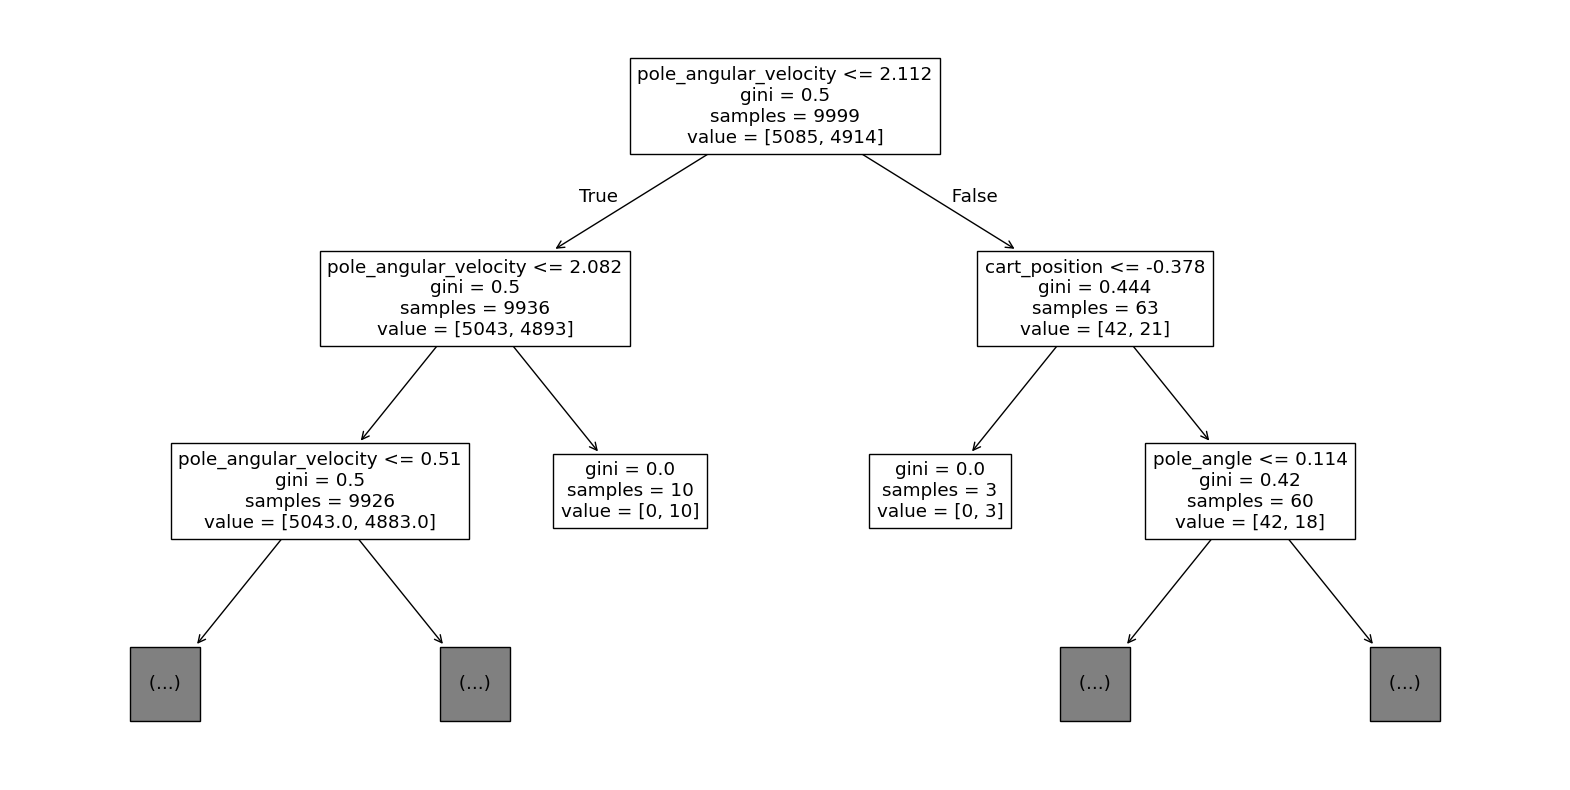

In [13]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20,10))
feature_names = ["cart_position", "cart_velocity", "pole_angle", "pole_angular_velocity"]

plot_tree(model, max_depth=2, feature_names=feature_names, ax=ax);

In [14]:
class ModelAgent(Agent):
    def __init__(self, model):
        self.model = model
    
    def act(self, observation):
        action = self.model.predict(observation.reshape(1,4)).item()
        return action

In [15]:
agent = ModelAgent(model)

evaluate_agent(agent)

22.5

In [16]:
agent.model

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [17]:
play_episode(agent)

Authorization required, but no authorization protocol specified



## Bookmarks

- [Brockman et al.: "OpenAI Gym" (2016)](https://arxiv.org/abs/1606.01540)
- [The CartPole Environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/)
- [Kaggle Intro to Reinforcement Learning](https://www.kaggle.com/learn/intro-to-game-ai-and-reinforcement-learning)
- [Gymnasium, the successor of OpenAI Gym](https://gymnasium.farama.org/)
- [Gymnasium Tutorials](https://gymnasium.farama.org/tutorials/index.html)